In [83]:
import pandas as pd
import numpy as np
from fbprophet import Prophet as prophet
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap as cmap

plt.rcParams.update(mpl.rcParamsDefault)
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['axes.facecolor'] = 'f4f4f4'
plt.rcParams['font.family'] = 'Palatino'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams['lines.linewidth'] = 2
pd.options.display.max_rows = 10


%config InlineBackend.figure_format = 'retina'

In [43]:
def retrieve(code, label):
    url = 'https://fred.stlouisfed.org/graph/fredgraph.csv?id=' + code
    df = pd.read_csv(url, index_col=0, parse_dates=True)
    df.columns, df.index.name = [label], None
    all_dates = pd.date_range(df.index.min(), df.index.max(), freq='D')
    df = df.replace('.', None).reindex(all_dates).fillna(method='ffill')
    return df.astype('float')

In [36]:
bond = retrieve('BAMLC0A1CAAAEY', 'bond')
bond

,bond
1996-12-31,6.72
1997-01-01,6.72
1997-01-02,6.80
1997-01-03,6.80
1997-01-04,6.80
...,...
2019-01-10,3.52
2019-01-11,3.50
2019-01-12,3.50
2019-01-13,3.50


In [37]:
treasury = retrieve('DGS10', 'treasury')
treasury

,treasury
1962-01-02,4.06
1962-01-03,4.03
1962-01-04,3.99
1962-01-05,4.02
1962-01-06,4.02
...,...
2019-01-10,2.74
2019-01-11,2.71
2019-01-12,2.71
2019-01-13,2.71


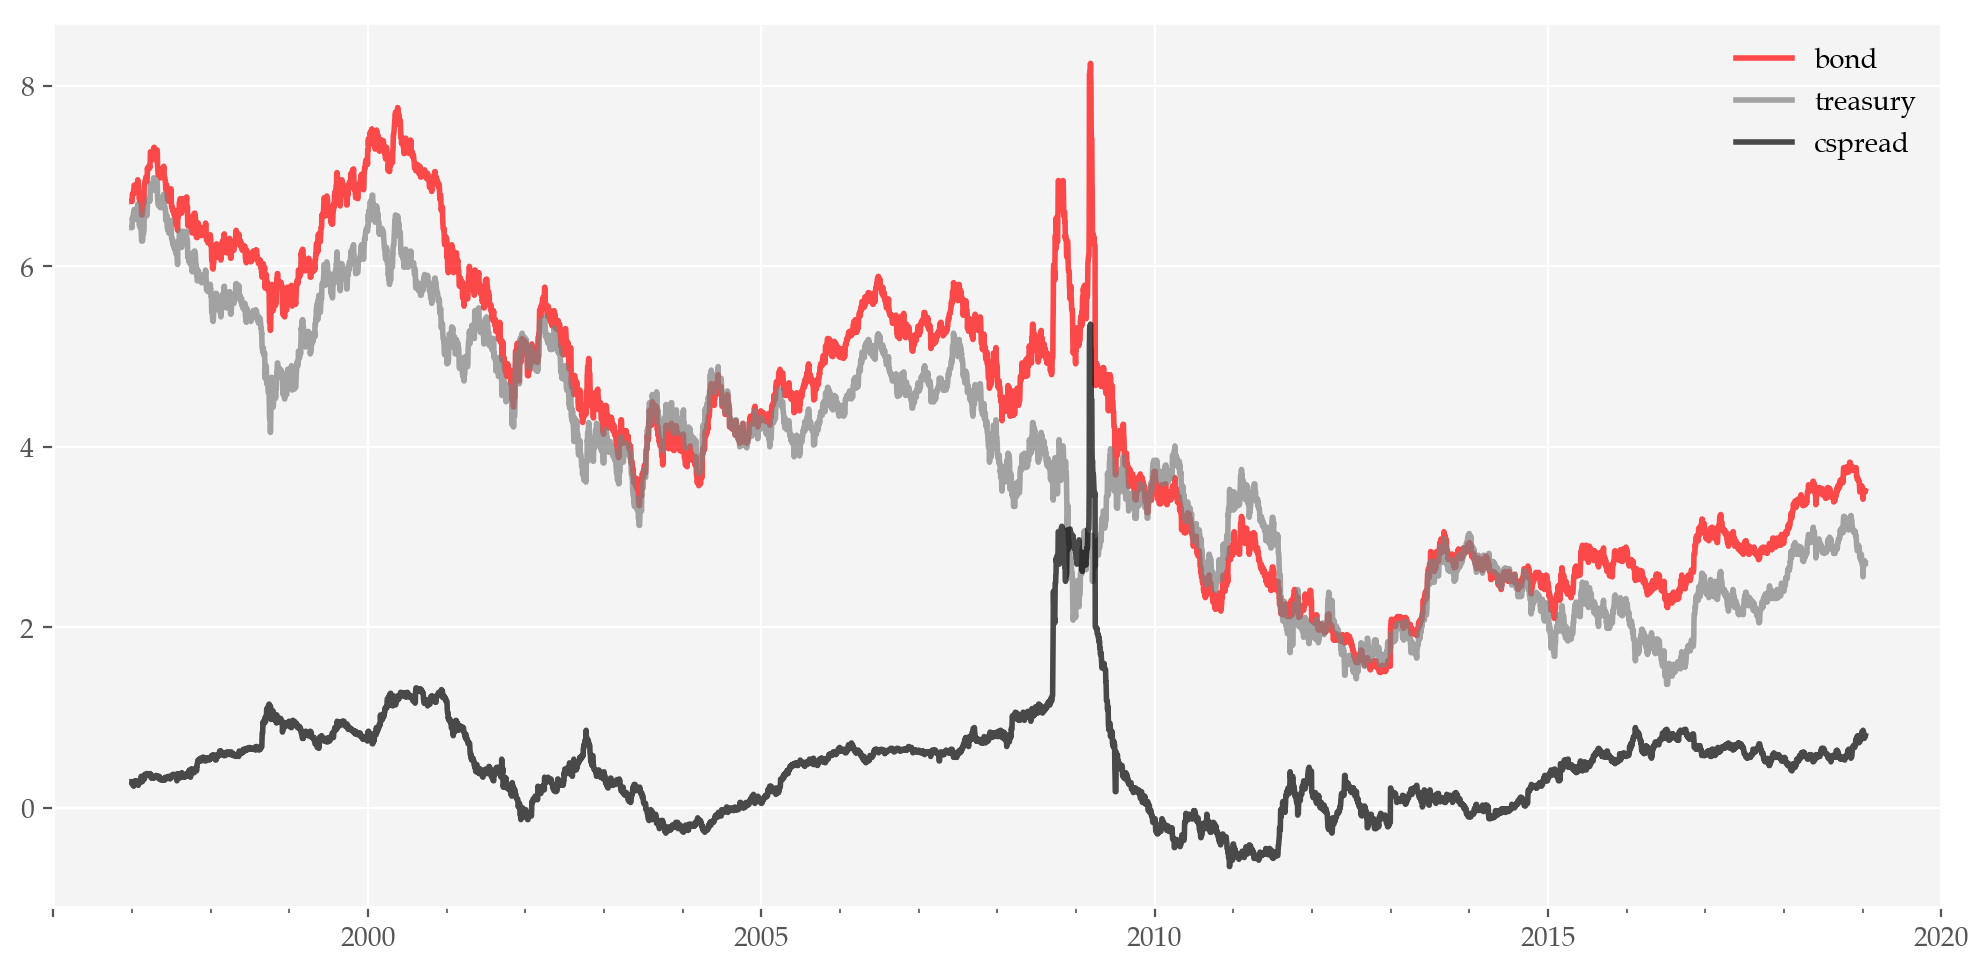

,bond,treasury,cspread
1996-12-31,6.72,6.43,0.29
1997-01-01,6.72,6.43,0.29
1997-01-02,6.80,6.54,0.26
1997-01-03,6.80,6.52,0.28
1997-01-04,6.80,6.52,0.28
...,...,...,...
2019-01-10,3.52,2.74,0.78
2019-01-11,3.50,2.71,0.79
2019-01-12,3.50,2.71,0.79
2019-01-13,3.50,2.71,0.79


In [152]:
data = bond.join(treasury)
data['cspread'] = data['bond'] - data['treasury']
fig = plt.figure()
ax = fig.add_subplot(111)
data.plot(ax=ax, alpha=.7, colormap=cmap(['r', 'grey', 'k']))
plt.tight_layout()
plt.legend(frameon=False)
plt.xlim(pd.datetime(data.index.min().year, 1, 1),
         pd.datetime(data.index.max().year + 1, 1, 1))
plt.show()
data

In [78]:
model = prophet(daily_seasonality=True)
df = pd.DataFrame({'ds': data.index, 'y': data.cspread})
model.fit(df)

In [79]:
future = model.make_future_dataframe(periods=365)
future.tail()

,ds
8410,2020-01-10
8411,2020-01-11
8412,2020-01-12
8413,2020-01-13
8414,2020-01-14


In [121]:
forecast = model.predict(future)
forecast.set_index('ds', inplace=True)
forecast.index.name = None
all_dates = pd.date_range(forecast.index.min(), forecast.index.max(), freq='D')
forecast = forecast.reindex(all_dates)[['yhat', 'yhat_lower', 'yhat_upper']]
forecast.tail()

,yhat,yhat_lower,yhat_upper
2020-01-10,0.837341,0.104194,1.541721
2020-01-11,0.837513,0.029781,1.596327
2020-01-12,0.837966,0.052315,1.573510
2020-01-13,0.836555,0.068955,1.550139
2020-01-14,0.834528,0.046105,1.562040


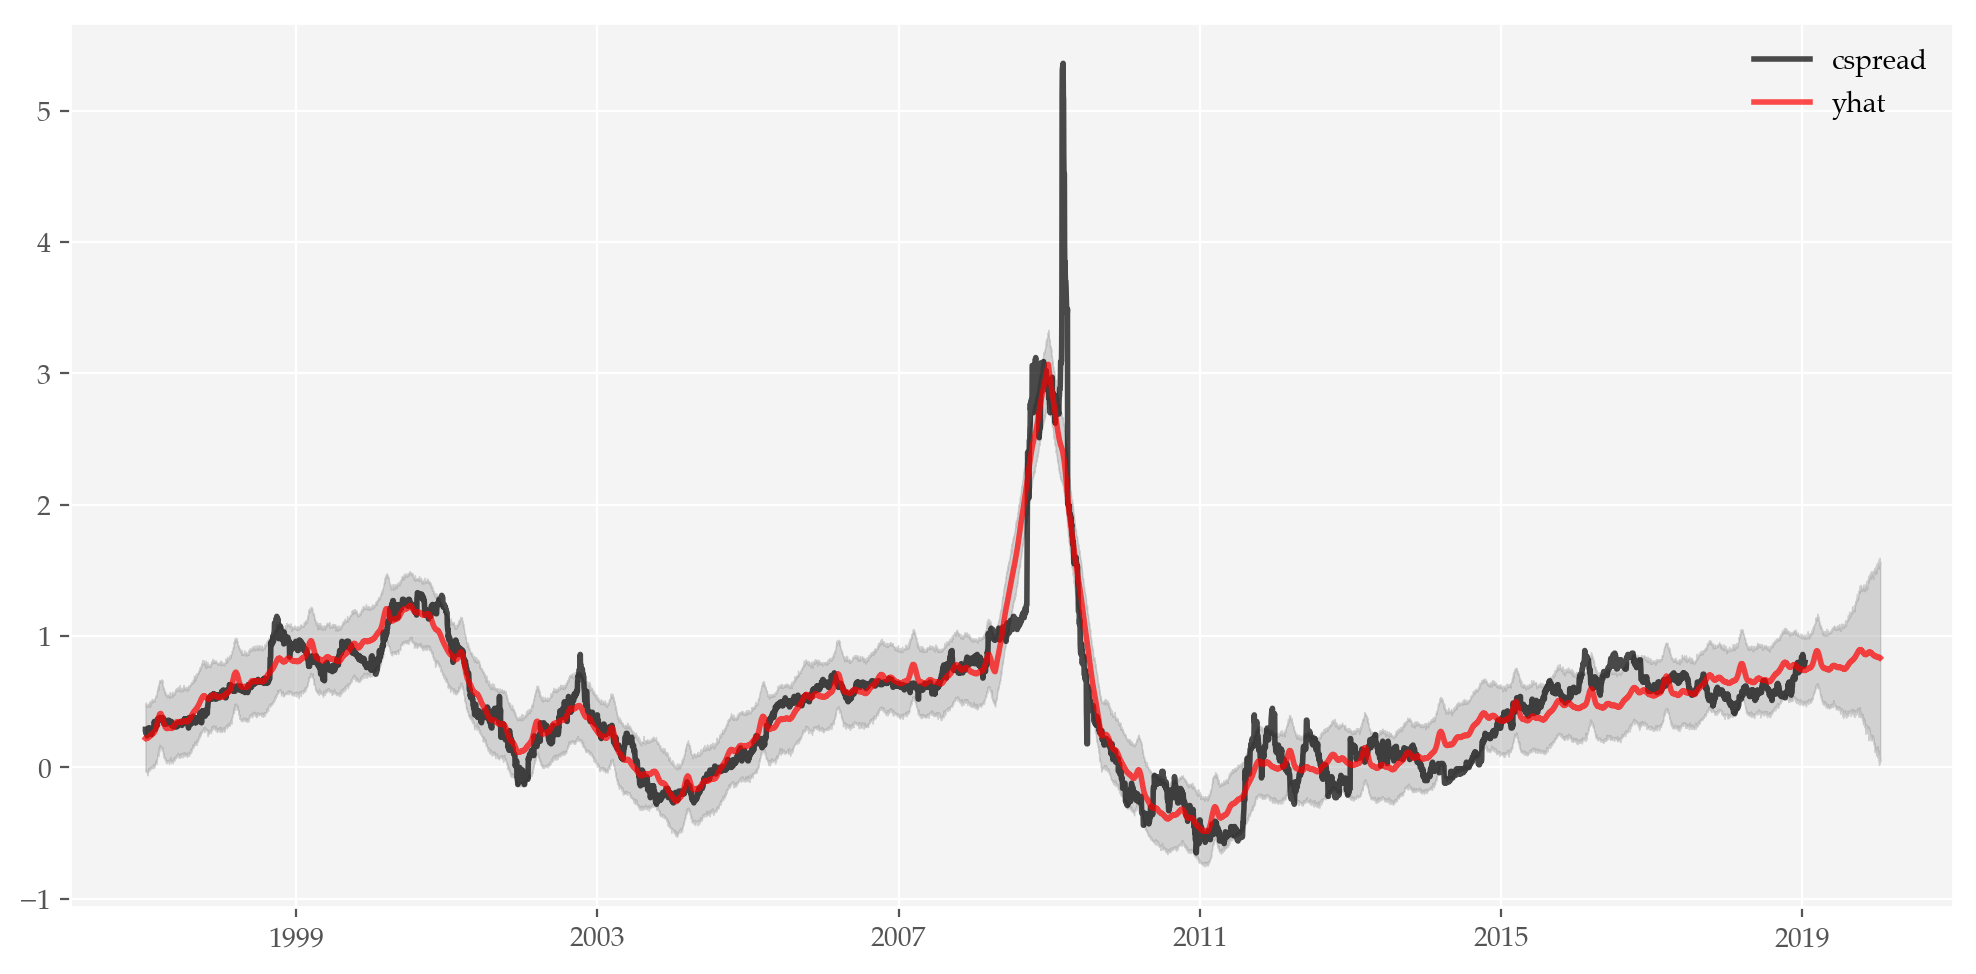

In [153]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.fill_between(x=forecast.index, y1=forecast.yhat_lower, y2=forecast.yhat_upper, color='grey', alpha=.3)
ax.plot(data.index, data.cspread, color='k', alpha=.7)
ax.plot(forecast.index, forecast.yhat, color='r', alpha=.7)
plt.tight_layout()
plt.xlabel('')
plt.xlim(pd.datetime(data.index.min().year, 1, 1),
         pd.datetime(data.index.max().year + 2, 1, 1))
plt.legend(frameon=False)
plt.show()

In [157]:
y = data.cspread.values
yhat = forecast.yhat[:data.shape[0]]
err = (y - yhat).values
mse = (err**2).mean()
mse

0.038901287684851675

Click [here](http://allenfrostline.com/)